In [1]:
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API

In [2]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [3]:
with open("timeseries.json", "rt") as INFILE:
    data = json.load(INFILE)

In [4]:
def wrangle_data(rawdata):

    datalist=data['data']
    dates=[dictionary['date'] for dictionary in datalist ]
    dates.sort()
    def parse_date(datestring):
        """ Convert a date string into a pandas datetime object """
        return pd.to_datetime(datestring, format="%Y-%m-%d")
    startdate=parse_date(dates[0])
    enddate=parse_date(dates[-1])
    index=pd.date_range(startdate, enddate, freq='D')
    timeseriesdf=pd.DataFrame(index=index, columns=['cases', 'hospital', 'deaths'])

    for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
        date=parse_date(entry['date'])
        for column in ['cases', 'hospital', 'deaths']:
            # check that nothing is there yet - just in case some dates are duplicated,
            # maybe with data for different columns in each entry
            if pd.isna(timeseriesdf.loc[date, column]): 
                # replace None with 0 in our data 
                value= float(entry[column]) if entry[column]!=None else 0.0
                # this is the way you access a specific location in the dataframe - use .loc
                # and put index,column in a single set of [ ]
                timeseriesdf.loc[date, column]=value
            
    # fill in any remaining "holes" due to missing dates
    timeseriesdf.fillna(0.0, inplace=True)
    return timeseriesdf

# putting the wrangling code into a function allows you to call it again after refreshing the data through 
# the API. You should call the function directly on the JSON data when the dashboard starts, by including 
# the call in the cell as below:
df=wrangle_data(data) # df is the dataframe for plotting



In [5]:
# Place your API access code in this function. Do not call this function directly; it will be called by 
# the button callback. 
def access_api():
    """ Accesses the PHE API. Returns raw data in the same format as data loaded from the "canned" JSON file. """
    filters = [
    'areaType=overview' # note each metric-value pair is inside one string
    ]
    structure = {
    "date": "date",
    "cases": "newCasesByPublishDate",
    "hospital": "newAdmissions",
    "deaths": "cumDeaths28DaysByDeathDateRate"    
    }
    api = Cov19API(filters=filters, structure=structure)
    return {api} # return data read from the API


In [6]:
# Printout from this function will be lost in Voila unless captured in an
# output widget - therefore, we give feedback to the user by changing the 
# appearance of the button
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling
    # around this call.
    apidata=access_api()
    # wrangle the data and overwrite the dataframe for plotting
    global df
    df=wrangle_data(apidata)
    
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # you can omit this step in the first instance
    #refresh_graph()
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. You can use icons
    # "unlink" or "times" and change the button text to "Unavailable" in case the 
    # api call fails.
    apibutton.icon="check"
    # apibutton.disabled=True
    
apibutton=wdg.Button(
    description='PANIC', # you may want to change this...
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Keep calm and carry on",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='exclamation-triangle'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

display(apibutton)

# run all cells before clicking on this button

Button(button_style='danger', description='PANIC', icon='exclamation-triangle', style=ButtonStyle(), tooltip='…

In [7]:
series=wdg.SelectMultiple(
    options=['cases', 'hospital', 'deaths'],
    value=['cases', 'hospital', 'deaths'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

# try replacing HBox with a VBox
controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        df[list(gcols)].plot(logy=logscale)
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); capture output in variable graph   
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

Output()

In [8]:
### all nations cases ###

all_nations = [
    "areaType=nation"
]

cases_and_deaths = {
    "date": "date",
    "Cases": "cumCasesByPublishDate",
    
}

api = Cov19API(
    filters=all_nations,
    structure=cases_and_deaths
)

allnations = api.get_dataframe()

    


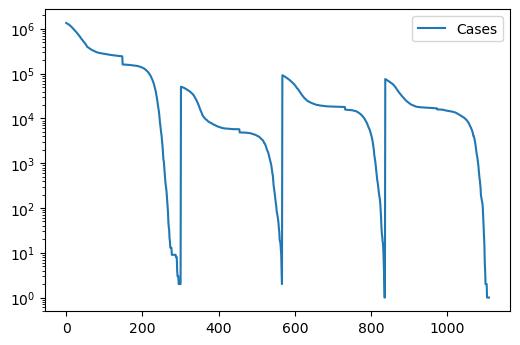

In [9]:
allnations.plot(logy=True)

In [10]:
england_only = [
    'areaType=nation',
    'areaName=England'
]

ases_and_deaths = {
    "date": "date",
    "areaName": "areaName",
    "areaCode": "areaCode",
    "newCasesByPublishDate": "newCasesByPublishDate",
    "cumCasesByPublishDate": "cumCasesByPublishDate",
    "newDeathsByDeathDate": "newDeathsByDeathDate",
    "cumDeathsByDeathDate": "cumDeathsByDeathDate"
}

api = Cov19API(filters=england_only, structure=cases_and_deaths)

englanddata = api.get_json()

with open("englanddata.json", "wt") as OUTF:
    json.dump(englanddata, OUTF)